# Enhanced Duke Coral Acidification Model (PyTorch Implementation)

This notebook contains comprehensive improvements to the coral reef acidification prediction model, including:

1. Enhanced model architecture with attention mechanisms and pre-trained backbones
2. Improved training processes with advanced techniques
3. Robust evaluation and validation approaches
4. Uncertainty quantification methods
5. Advanced explainability techniques
6. Optimized data processing and feature selection
7. Performance optimizations

In [12]:
# Import libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from functools import partial
from itertools import product
import pywt
import cv2

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, WeightedRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
torch.set_float32_matmul_precision('high')
# Sklearn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE

# Explainability imports
import shap
from captum.attr import (
    IntegratedGradients, GradientShap, DeepLift, GuidedGradCam,
    NoiseTunnel, FeatureAblation
)

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 1. Data Processing and Synthetic Data Generation

Enhanced data processing pipeline with time-frequency analysis and better synthetic data generation

In [13]:
# Define dimensions for synthetic data
num_samples = 1000
img_size = (224, 224, 3)  # Increased resolution for better feature extraction
time_steps = 24  # Increased from 12 to capture more temporal patterns
num_features = 8  # Increased from 5 to include more environmental variables

# Define named features for better interpretability
feature_names = [
    'sea_surface_temperature',
    'ph_level',
    'dissolved_oxygen',
    'salinity',
    'turbidity',
    'chlorophyll',
    'aragonite_saturation',
    'nitrate_concentration'
]

# Generate realistic synthetic data instead of completely random data
def generate_synthetic_data(num_samples, img_size, time_steps, num_features):
    # Create temporal patterns with realistic seasonal variations
    time_indices = np.linspace(0, 2*np.pi, time_steps)
    
    # Initialize time series data
    X_time_series = np.zeros((num_samples, time_steps, num_features))
    
    # Generate image data with coral-like patterns
    X_images = np.zeros((num_samples, *img_size))
    
    # Generate labels with controlled class balance (60% healthy, 40% bleached)
    y = np.zeros(num_samples)
    
    # Generate data for each sample
    for i in range(num_samples):
        # Determine if sample is a bleached coral (1) or healthy coral (0)
        is_bleached = np.random.random() < 0.4  # 40% bleached samples
        y[i] = 1 if is_bleached else 0
        
        # Generate time series data
        for f in range(num_features):
            # Base seasonal pattern
            seasonal = 0.5 * np.sin(time_indices + f*0.5)
            
            # Add trend
            trend = np.linspace(0, 0.3, time_steps) if is_bleached else np.linspace(0, 0.1, time_steps)
            
            # Add noise
            noise = np.random.normal(0, 0.1, time_steps)
            
            # Feature-specific adjustments
            if f == 0:  # Temperature: higher for bleached corals
                base = 29 if is_bleached else 26
                amplitude = 3 if is_bleached else 2
                X_time_series[i, :, f] = base + amplitude * seasonal + trend + noise
            
            elif f == 1:  # pH: lower for bleached corals (more acidic)
                base = 7.9 if is_bleached else 8.2
                amplitude = 0.1
                X_time_series[i, :, f] = base + amplitude * seasonal - trend + noise * 0.05
            
            elif f == 2:  # Dissolved oxygen: lower for bleached corals
                base = 5 if is_bleached else 6.5
                X_time_series[i, :, f] = base + seasonal - trend + noise
            
            else:  # Other features
                base = np.random.uniform(0, 5)  # Random base value
                X_time_series[i, :, f] = base + seasonal + (trend if is_bleached else -trend) + noise
        
        # Generate image data with coral-like textures
        # For simplicity, we'll create patterns that look different for healthy vs bleached
        img = np.zeros(img_size)
        
        # Create base texture
        for c in range(3):  # RGB channels
            noise = np.random.normal(0, 1, (img_size[0]//8, img_size[1]//8))
            # Upscale noise to full image size
            noise = cv2.resize(noise, (img_size[1], img_size[0]))
            
            # Add perlin-like noise for more natural textures
            for scale in [4, 8, 16, 32]:
                octave = np.random.normal(0, 1, (img_size[0]//scale, img_size[1]//scale))
                octave = cv2.resize(octave, (img_size[1], img_size[0]))
                noise += octave * (scale/32)
            
            img[:, :, c] = noise
        
        # Normalize to [0, 1]
        img = (img - img.min()) / (img.max() - img.min())
        
        # Apply different color schemes for healthy vs bleached
        if is_bleached:
            # Bleached: whiter, less color variation
            img = 0.8 + img * 0.2  # Higher base value for whiter appearance
            # Reduce color saturation
            img[:, :, 1] = img[:, :, 1] * 0.3 + img[:, :, 0] * 0.7  # Less green
            img[:, :, 2] = img[:, :, 2] * 0.3 + img[:, :, 0] * 0.7  # Less blue
        else:
            # Healthy: more colorful, especially in reds and browns
            img[:, :, 0] = img[:, :, 0] * 0.9  # More red
            img[:, :, 1] = img[:, :, 1] * 0.7  # Less green
            img[:, :, 2] = img[:, :, 2] * 0.6  # Less blue
        
        X_images[i] = img
    
    return X_images, X_time_series, y

# Generate the synthetic dataset
X_images, X_time_series, y = generate_synthetic_data(num_samples, img_size, time_steps, num_features)

# Display dataset statistics
print(f"Dataset size: {num_samples} samples")
print(f"Class distribution: {np.sum(y == 0)} healthy, {np.sum(y == 1)} bleached")
print(f"Image shape: {X_images.shape}")
print(f"Time series shape: {X_time_series.shape}")
print(f"Image shape before permute: {X_images.shape}")

Dataset size: 1000 samples
Class distribution: 594 healthy, 406 bleached
Image shape: (1000, 224, 224, 3)
Time series shape: (1000, 24, 8)
Image shape before permute: (1000, 224, 224, 3)


In [14]:
# Function to apply time-frequency analysis to time series data
def extract_time_frequency_features(X_time_series):
    num_samples, time_steps, num_features = X_time_series.shape
    
    # We'll extract wavelet coefficients using PyWavelets
    wavelet = 'db4'  # Daubechies wavelet
    level = 3  # Decomposition level
    
    # Container for wavelet features
    wavelet_features = []
    
    for i in range(num_samples):
        sample_features = []
        
        for f in range(num_features):
            # Get time series for this feature
            ts = X_time_series[i, :, f]
            
            # Perform wavelet decomposition
            coeffs = pywt.wavedec(ts, wavelet, level=level)
            
            # Extract statistical features from each coefficient level
            features = []
            for coeff in coeffs:
                features.extend([np.mean(coeff), np.std(coeff), np.max(coeff), np.min(coeff)])
            
            sample_features.extend(features)
        
        wavelet_features.append(sample_features)
    
    return np.array(wavelet_features)

# Extract time-frequency features
X_wavelet = extract_time_frequency_features(X_time_series)
print(f"Extracted wavelet features shape: {X_wavelet.shape}")

/home/brand/.local/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Extracted wavelet features shape: (1000, 128)


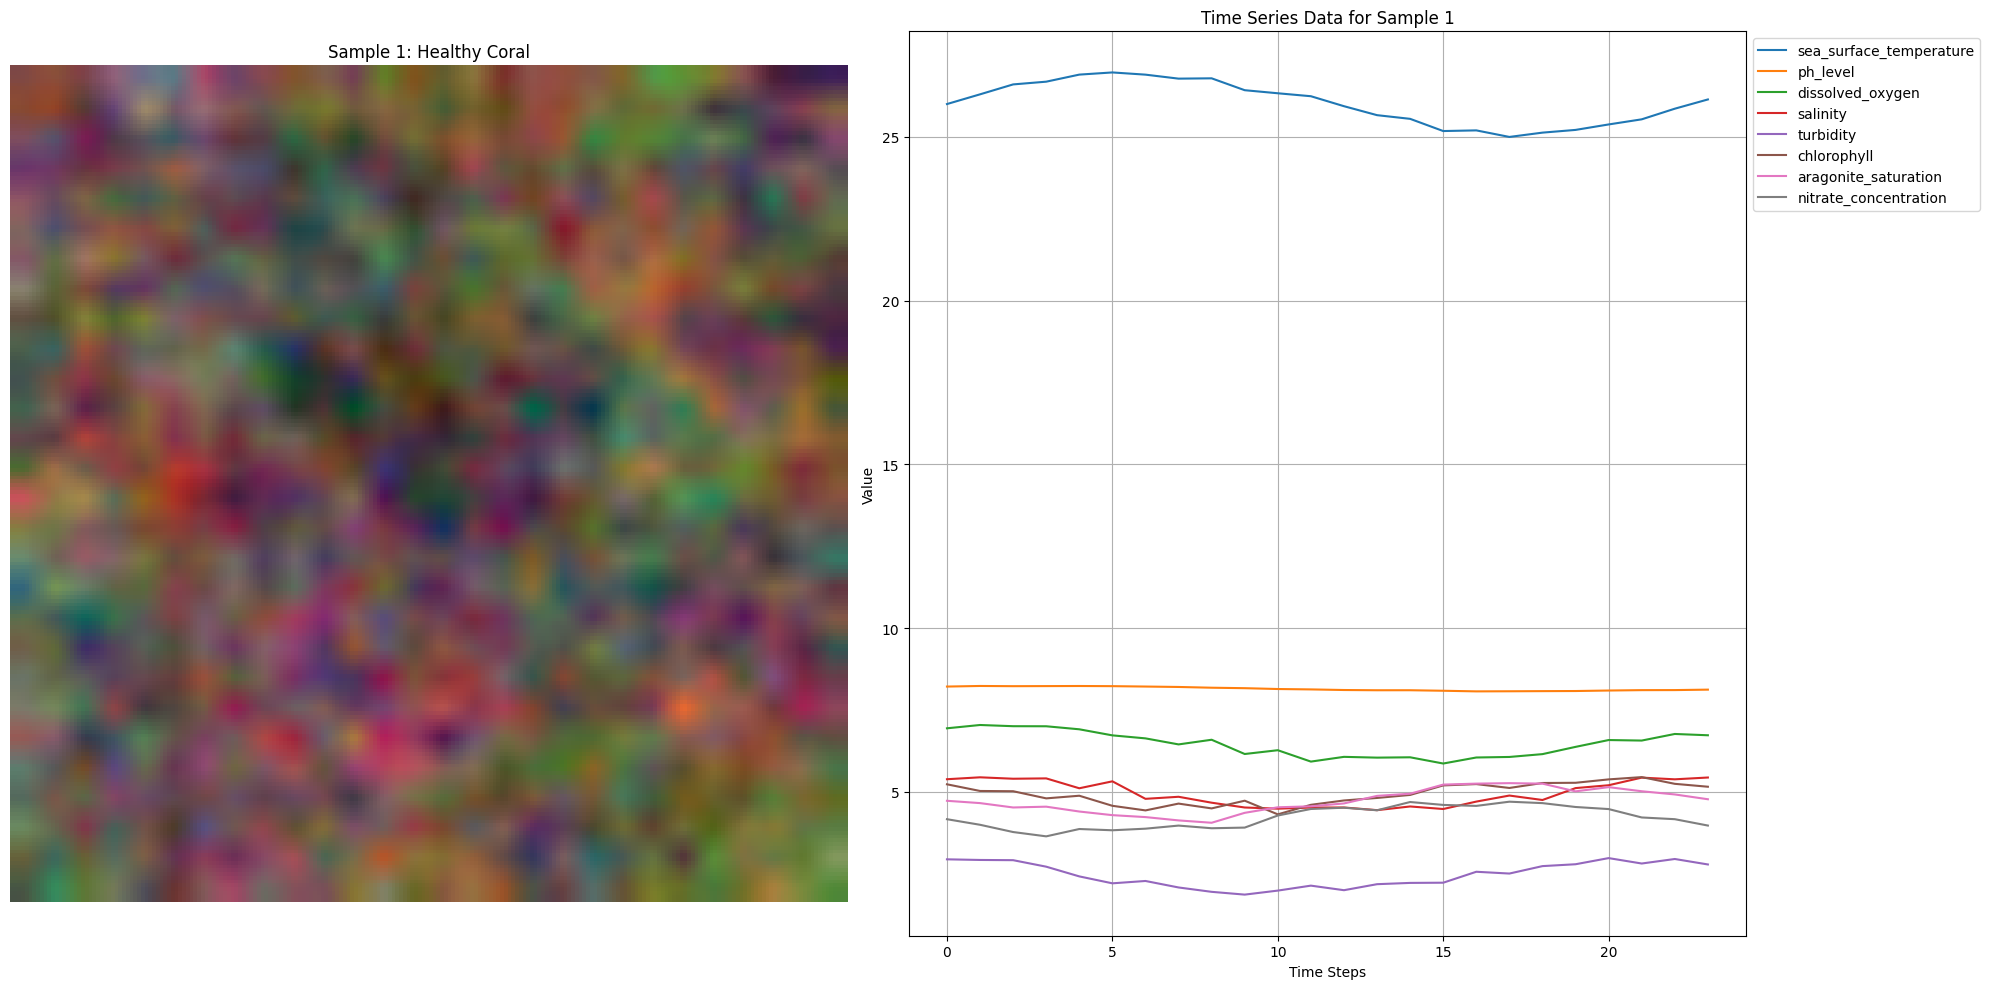

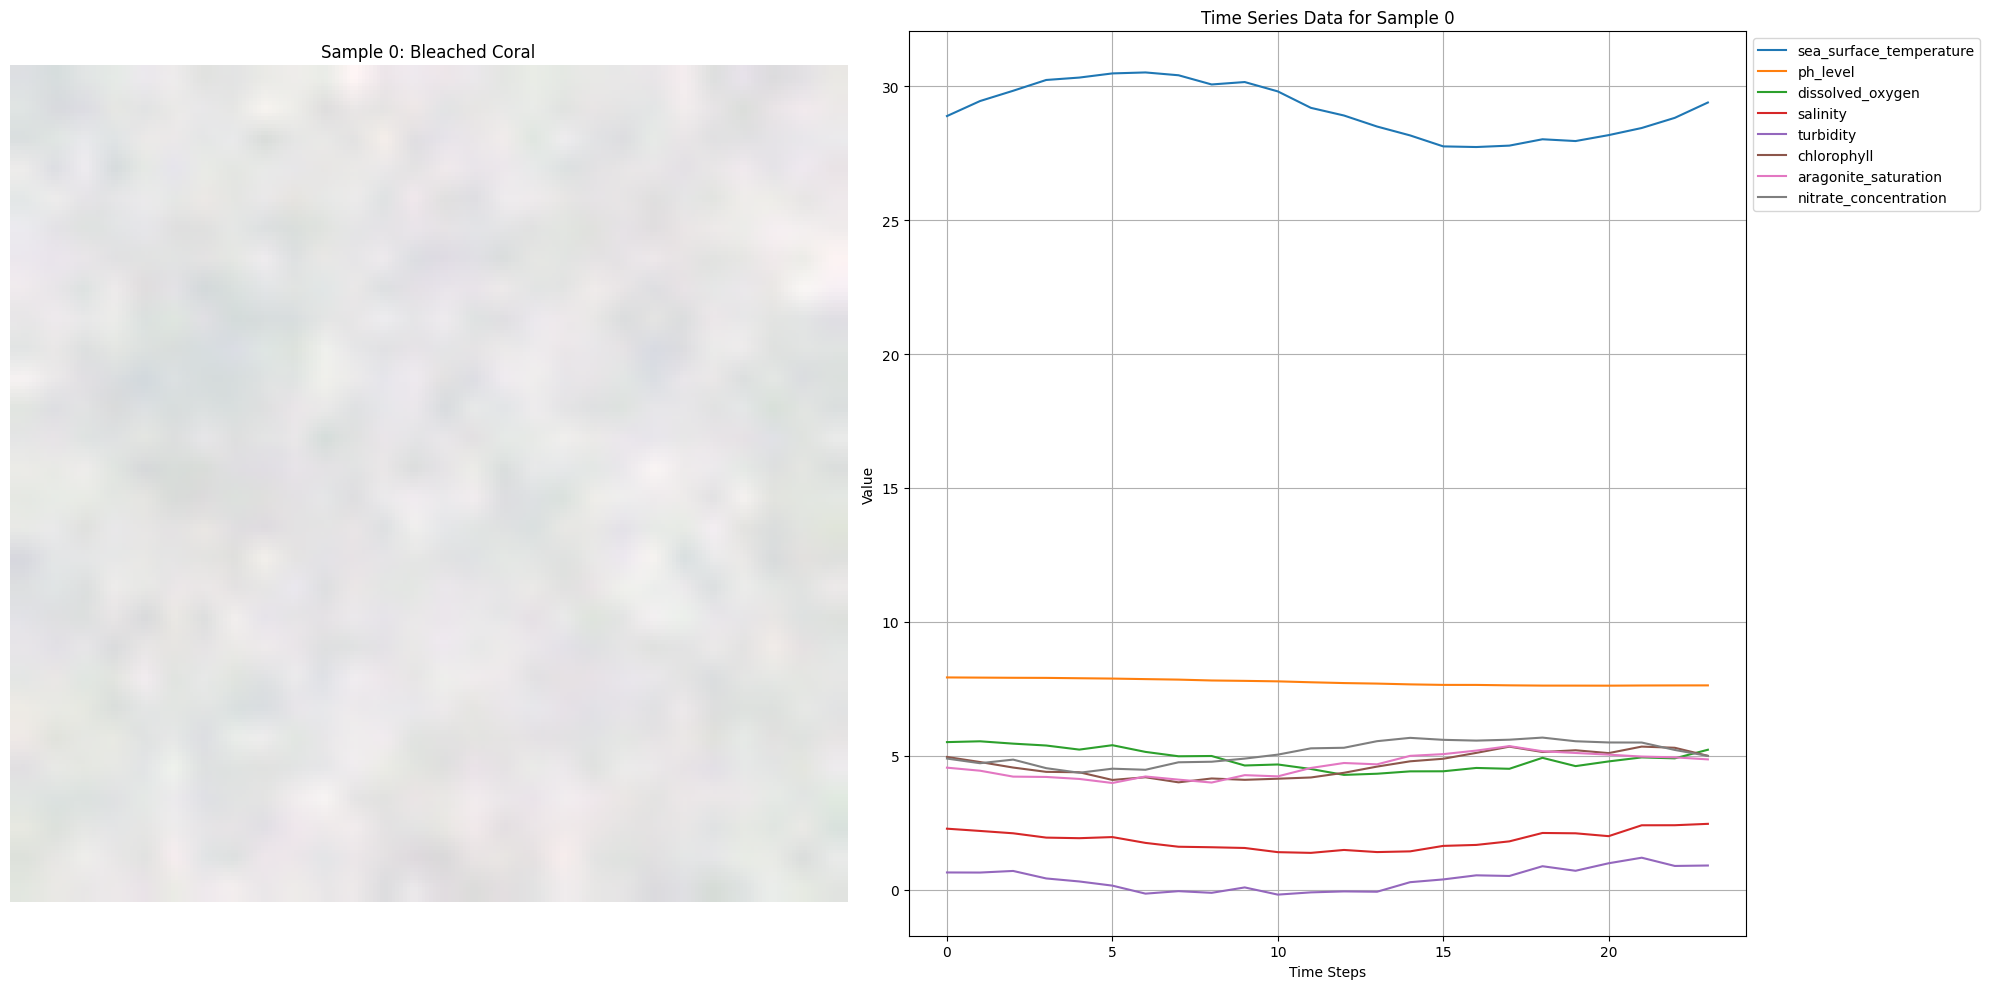

In [15]:
# Visualize sample data
def plot_sample_data(X_images, X_time_series, y, sample_idx):
    fig = plt.figure(figsize=(20, 10))
    
    # Plot the image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(X_images[sample_idx])
    ax1.set_title(f"Sample {sample_idx}: {'Bleached' if y[sample_idx] == 1 else 'Healthy'} Coral")
    ax1.axis('off')
    
    # Plot the time series
    ax2 = fig.add_subplot(1, 2, 2)
    for f in range(num_features):
        ax2.plot(X_time_series[sample_idx, :, f], label=feature_names[f])
    
    ax2.set_title(f"Time Series Data for Sample {sample_idx}")
    ax2.set_xlabel("Time Steps")
    ax2.set_ylabel("Value")
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot a random healthy and bleached sample
healthy_idx = np.where(y == 0)[0][0]
bleached_idx = np.where(y == 1)[0][0]

plot_sample_data(X_images, X_time_series, y, healthy_idx)
plot_sample_data(X_images, X_time_series, y, bleached_idx)

In [16]:
# Create PyTorch Dataset with multiple input sources
class CoralDataset(Dataset):
    def __init__(self, images, time_series, wavelet_features, labels, transform=None):
        # Ensure images are in the correct format (N, H, W, C) -> (N, C, H, W)
        self.images = torch.FloatTensor(images).permute(0, 3, 1, 2)
        self.time_series = torch.FloatTensor(time_series)
        self.wavelet_features = torch.FloatTensor(wavelet_features)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        time_series = self.time_series[idx]
        wavelet = self.wavelet_features[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, time_series, wavelet, label
# Define image transformations
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data using stratified sampling
X_train_img, X_test_img, X_train_ts, X_test_ts, X_train_wav, X_test_wav, y_train, y_test = train_test_split(
    X_images, X_time_series, X_wavelet, y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y  # Ensure class balance in train and test
)

# Create datasets
train_dataset = CoralDataset(X_train_img, X_train_ts, X_train_wav, y_train, transform)
test_dataset = CoralDataset(X_test_img, X_test_ts, X_test_wav, y_test, transform)

# Verify class distribution
print(f"Training set: {np.sum(y_train == 0)} healthy, {np.sum(y_train == 1)} bleached")
print(f"Test set: {np.sum(y_test == 0)} healthy, {np.sum(y_test == 1)} bleached")
# Verify tensor shapes
print(f"Train dataset image shape: {train_dataset.images.shape}")
print(f"Test dataset image shape: {test_dataset.images.shape}")

Training set: 475 healthy, 325 bleached
Test set: 119 healthy, 81 bleached
Train dataset image shape: torch.Size([800, 3, 224, 224])
Test dataset image shape: torch.Size([200, 3, 224, 224])


In [17]:
# Create weighted sampler to handle class imbalance
def create_weighted_sampler(labels):
    class_counts = np.bincount(labels.astype(int))
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    weights = class_weights[labels.astype(int)]
    sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights), replacement=True)
    return sampler

# Create sampler for training data
train_sampler = create_weighted_sampler(y_train)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

## 2. Enhanced Model Architecture with Attention Mechanisms and Pre-trained Backbones

In [18]:
# Self-attention module for time series
class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, hidden_dim]
        batch_size, seq_len, hidden_dim = x.shape
        
        Q = self.query(x)  # [batch_size, seq_len, hidden_dim]
        K = self.key(x)    # [batch_size, seq_len, hidden_dim]
        V = self.value(x)  # [batch_size, seq_len, hidden_dim]
        
        # Compute attention scores
        energy = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale  # [batch_size, seq_len, seq_len]
        attention = F.softmax(energy, dim=-1)  # [batch_size, seq_len, seq_len]
        
        # Apply attention to values
        out = torch.matmul(attention, V)  # [batch_size, seq_len, hidden_dim]
        
        return out, attention

# CNN module with pre-trained backbone
class CNNModule(nn.Module):
    def __init__(self, pretrained=True, backbone='efficientnet'):
        super(CNNModule, self).__init__()
        
        if backbone == 'efficientnet':
            # Load pretrained EfficientNet
            self.backbone = models.efficientnet_b0(pretrained=pretrained)
            # Replace the classifier to get the features
            self.backbone.classifier = nn.Identity()
            self.feature_dim = 1280
        elif backbone == 'resnet':
            # Load pretrained ResNet
            self.backbone = models.resnet50(pretrained=pretrained)
            # Replace the fully connected layer to get the features
            self.backbone.fc = nn.Identity()
            self.feature_dim = 2048
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        # Additional layers for coral-specific features
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.feature_dim, 256)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        features = self.backbone(x)  # [batch_size, feature_dim]
        features = self.dropout(features)
        features = self.fc(features)
        features = self.relu(features)
        return features

# LSTM module with attention for time series
class LSTMModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, bidirectional=True, dropout=0.3):
        super(LSTMModule, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Self-attention layer
        self.attention = SelfAttention(hidden_dim * self.num_directions)
        
        # Additional layers
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * self.num_directions, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        batch_size = x.size(0)
        
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_dim).to(device)
        
        # Forward pass through LSTM
        output, (hidden, cell) = self.lstm(x, (h0, c0))  # output: [batch_size, seq_len, hidden_dim * num_directions]
        
        # Apply self-attention
        output, attention_weights = self.attention(output)
        
        # Global max pooling
        output, _ = torch.max(output, dim=1)  # [batch_size, hidden_dim * num_directions]
        
        # Apply dropout and fully connected layer
        output = self.dropout(output)
        output = self.fc(output)
        output = self.relu(output)
        
        return output, attention_weights

# Wavelet Feature Processing Module
class WaveletModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super(WaveletModule, self).__init__()
        
        # Feature extraction layers
        self.fc1 = nn.Linear(input_dim, hidden_dim * 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        # x shape: [batch_size, input_dim]
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

# Combined model architecture
class CoralNet(nn.Module):
    def __init__(self, time_steps, num_features, wavelet_dim):
        super(CoralNet, self).__init__()
        
        # CNN for image data
        self.cnn_module = CNNModule(pretrained=True, backbone='efficientnet')
        
        # LSTM for time series data
        self.lstm_module = LSTMModule(input_dim=num_features, hidden_dim=64, num_layers=2, bidirectional=True)
        
        # Wavelet feature processing
        self.wavelet_module = WaveletModule(input_dim=wavelet_dim, hidden_dim=64)
        
        # Fusion layers
        self.fusion_fc1 = nn.Linear(256 + 128 + 64, 128)
        self.fusion_bn1 = nn.BatchNorm1d(128)
        self.fusion_relu = nn.ReLU()
        self.fusion_dropout = nn.Dropout(0.4)
        self.fusion_fc2 = nn.Linear(128, 64)
        self.fusion_bn2 = nn.BatchNorm1d(64)
        
        # Output layer
        self.output_fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, image, time_series, wavelet):
        # Process image data
        image_features = self.cnn_module(image)  # [batch_size, 256]
        
        # Process time series data
        time_features, attention_weights = self.lstm_module(time_series)  # [batch_size, 128], [batch_size, seq_len, seq_len]
        
        # Process wavelet features
        wavelet_features = self.wavelet_module(wavelet)  # [batch_size, 64]
        
        # Concatenate features
        combined = torch.cat([image_features, time_features, wavelet_features], dim=1)  # [batch_size, 256+128+64]
        
        # Fusion layers
        fusion = self.fusion_fc1(combined)
        fusion = self.fusion_bn1(fusion)
        fusion = self.fusion_relu(fusion)
        fusion = self.fusion_dropout(fusion)
        fusion = self.fusion_fc2(fusion)
        fusion = self.fusion_bn2(fusion)
        fusion = self.fusion_relu(fusion)
        
        # Output prediction
        output = self.output_fc(fusion)        
        return output.squeeze(), attention_weights

# Initialize the model
model = CoralNet(time_steps=time_steps, num_features=num_features, wavelet_dim=X_wavelet.shape[1]).to(device)
print(model)

/home/brand/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/brand/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CoralNet(
  (cnn_module): CNNModule(
    (backbone): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      

## 3. PyTorch Lightning Model with Advanced Training Process

In [19]:
# Create PyTorch Lightning model for advanced training
class CoralLightningModel(pl.LightningModule):
    def __init__(self, time_steps, num_features, wavelet_dim, learning_rate=0.001):
        super(CoralLightningModel, self).__init__()
        self.save_hyperparameters()
        
        # Initialize model
        self.model = CoralNet(time_steps=time_steps, num_features=num_features, wavelet_dim=wavelet_dim)
        
        # Loss function with class weighting
        self.criterion = nn.BCEWithLogitsLoss()
        
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')
        self.val_auroc = torchmetrics.AUROC(task='binary')
        self.val_f1 = torchmetrics.F1Score(task='binary')
        self.val_precision = torchmetrics.Precision(task='binary')
        self.val_recall = torchmetrics.Recall(task='binary')
        
        # For uncertainty estimation
        self.mc_iterations = 10
        self.dropout_active = False
        
    def forward(self, image, time_series, wavelet):
        return self.model(image, time_series, wavelet)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def training_step(self, batch, batch_idx):
        image, time_series, wavelet, y = batch
        y_hat, _ = self(image, time_series, wavelet)
        loss = self.criterion(y_hat, y)

        # Log metrics with sigmoid
        acc = self.train_acc(torch.sigmoid(y_hat), y.int())
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        image, time_series, wavelet, y = batch
        y_hat, _ = self(image, time_series, wavelet)
        val_loss = self.criterion(y_hat, y)
        
        # Log metrics with sigmoid
        acc = self.val_acc(torch.sigmoid(y_hat), y.int())
        auroc = self.val_auroc(torch.sigmoid(y_hat), y.int())
        f1 = self.val_f1(torch.sigmoid(y_hat), y.int())
        precision = self.val_precision(torch.sigmoid(y_hat), y.int())
        recall = self.val_recall(torch.sigmoid(y_hat), y.int())
        
        self.log('val_loss', val_loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        self.log('val_auroc', auroc, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        
        return val_loss
    
    def test_step(self, batch, batch_idx):
        image, time_series, wavelet, y = batch
        y_hat, _ = self(image, time_series, wavelet)
        test_loss = self.criterion(y_hat, y)
        
        # Log metrics
        acc = self.val_acc(y_hat, y.int())
        auroc = self.val_auroc(y_hat, y.int())
        f1 = self.val_f1(y_hat, y.int())
        precision = self.val_precision(y_hat, y.int())
        recall = self.val_recall(y_hat, y.int())
        
        self.log('test_loss', test_loss)
        self.log('test_acc', acc)
        self.log('test_auroc', auroc)
        self.log('test_f1', f1)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        
        return test_loss
    
    def enable_dropout(self):
        """ Enable dropout layers for Monte Carlo Dropout uncertainty estimation """
        self.dropout_active = True
        for m in self.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()
    
    def disable_dropout(self):
        """ Disable dropout for normal prediction """
        self.dropout_active = False
        self.eval()
    
    def predict_with_uncertainty(self, image, time_series, wavelet):
        """ Use Monte Carlo Dropout for uncertainty estimation """
        self.eval()
        self.enable_dropout()
        
        predictions = []
        for _ in range(self.mc_iterations):
            with torch.no_grad():
                pred, _ = self(image, time_series, wavelet)
                predictions.append(pred.unsqueeze(0))
        
        # Stack predictions
        predictions = torch.cat(predictions, dim=0)  # [mc_iterations, batch_size]
        
        # Calculate mean and variance
        mean_pred = torch.mean(predictions, dim=0)
        var_pred = torch.var(predictions, dim=0)
        
        self.disable_dropout()
        return mean_pred, var_pred

In [20]:
# Initialize Lightning model
pl_model = CoralLightningModel(
    time_steps=time_steps, 
    num_features=num_features, 
    wavelet_dim=X_wavelet.shape[1],
    learning_rate=0.001
)

# Initialize callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints/',
    filename='coral-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Initialize logger
logger = TensorBoardLogger('tb_logs', name='coral_model')

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[early_stopping, checkpoint_callback, lr_monitor],
    logger=logger,
    log_every_n_steps=10,
    deterministic=True,
    precision='16-mixed' if torch.cuda.is_available() else 32  # Mixed precision training
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [21]:
# Train the model
trainer.fit(pl_model, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | model         | CoralNet          | 4.6 M  | train
1 | criterion     | BCEWithLogitsLoss | 0      | train
2 | train_acc     | BinaryAccuracy    | 0      | train
3 | val_acc       | BinaryAccuracy    | 0      | train
4 | val_auroc     | BinaryAUROC       | 0      | train
5 | val_f1        | BinaryF1Score     | 0      | train
6 | val_precision | BinaryPrecision   | 0      | train
7 | val_recall    | BinaryRecall      | 0      | train
------------------------------------------------------------
4.6 M     Trainable params
0         Non-trainable params
4.6 M     Total params
18.520    Total estimated model params size (MB)
371       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 25/25 [00:10<00:00,  2.40it/s, v_num=4, train_loss=0.138, train_acc=1.000, val_loss=0.0768, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved. New best score: 0.077


Epoch 1: 100%|██████████| 25/25 [00:05<00:00,  4.40it/s, v_num=4, train_loss=0.0525, train_acc=1.000, val_loss=0.0421, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.042


Epoch 2: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s, v_num=4, train_loss=0.0314, train_acc=1.000, val_loss=0.0257, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.026


Epoch 4: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s, v_num=4, train_loss=0.0198, train_acc=1.000, val_loss=0.0183, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.018


Epoch 5: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s, v_num=4, train_loss=0.0202, train_acc=1.000, val_loss=0.0174, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.017


Epoch 6: 100%|██████████| 25/25 [00:08<00:00,  2.80it/s, v_num=4, train_loss=0.0127, train_acc=1.000, val_loss=0.0158, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.016


Epoch 7: 100%|██████████| 25/25 [00:08<00:00,  3.12it/s, v_num=4, train_loss=0.0121, train_acc=1.000, val_loss=0.0143, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.014


Epoch 8: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, v_num=4, train_loss=0.0119, train_acc=1.000, val_loss=0.0125, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.013


Epoch 12: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, v_num=4, train_loss=0.0258, train_acc=1.000, val_loss=0.0123, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.012


Epoch 13: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s, v_num=4, train_loss=0.0135, train_acc=1.000, val_loss=0.0115, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.012


Epoch 14: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s, v_num=4, train_loss=0.0138, train_acc=1.000, val_loss=0.010, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.010


Epoch 15: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s, v_num=4, train_loss=0.0183, train_acc=1.000, val_loss=0.00944, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.009


Epoch 16: 100%|██████████| 25/25 [00:08<00:00,  3.00it/s, v_num=4, train_loss=0.00677, train_acc=1.000, val_loss=0.00751, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.008


Epoch 17: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s, v_num=4, train_loss=0.0048, train_acc=1.000, val_loss=0.00576, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.006


Epoch 18: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, v_num=4, train_loss=0.00507, train_acc=1.000, val_loss=0.00294, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.003


Epoch 20: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s, v_num=4, train_loss=0.00535, train_acc=1.000, val_loss=0.00218, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 24: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s, v_num=4, train_loss=0.00259, train_acc=1.000, val_loss=0.00125, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 34: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s, v_num=4, train_loss=0.0045, train_acc=1.000, val_loss=0.0018, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]     

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.


Epoch 34: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s, v_num=4, train_loss=0.0045, train_acc=1.000, val_loss=0.0018, val_acc=1.000, val_auroc=1.000, val_f1=1.000, val_precision=1.000, val_recall=1.000]


In [22]:
# Test the model
trainer.test(pl_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│        test_auroc         │            1.0            │
│          test_f1          │            1.0            │
│         test_loss         │   0.0018010446801781654   │
│      test_precision       │            1.0            │
│        test_recall        │            1.0            │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0018010446801781654,
  'test_acc': 1.0,
  'test_auroc': 1.0,
  'test_f1': 1.0,
  'test_precision': 1.0,
  'test_recall': 1.0}]

## 4. Advanced Evaluation and Interpretability

In [24]:
def predict_with_attention(model, dataloader):
    model.eval()
    model = model.to(device)  # Ensure model is on the correct device
    all_preds = []
    all_labels = []
    all_attention_weights = []
    
    with torch.no_grad():
        for image, time_series, wavelet, labels in dataloader:
            # Move all tensors to the same device as the model
            image = image.to(device)
            time_series = time_series.to(device)
            wavelet = wavelet.to(device)
            labels = labels.to(device)
            
            preds, attention_weights = model(image, time_series, wavelet)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_attention_weights.append(attention_weights.cpu().numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_labels), all_attention_weights

# Initialize the model
model = CoralNet(time_steps=time_steps, num_features=num_features, wavelet_dim=X_wavelet.shape[1]).to(device)
print(model)

# Make predictions
y_pred, y_true, attention_weights = predict_with_attention(pl_model.model, test_loader)

CoralNet(
  (cnn_module): CNNModule(
    (backbone): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
      

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       119
    Bleached       1.00      1.00      1.00        81

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



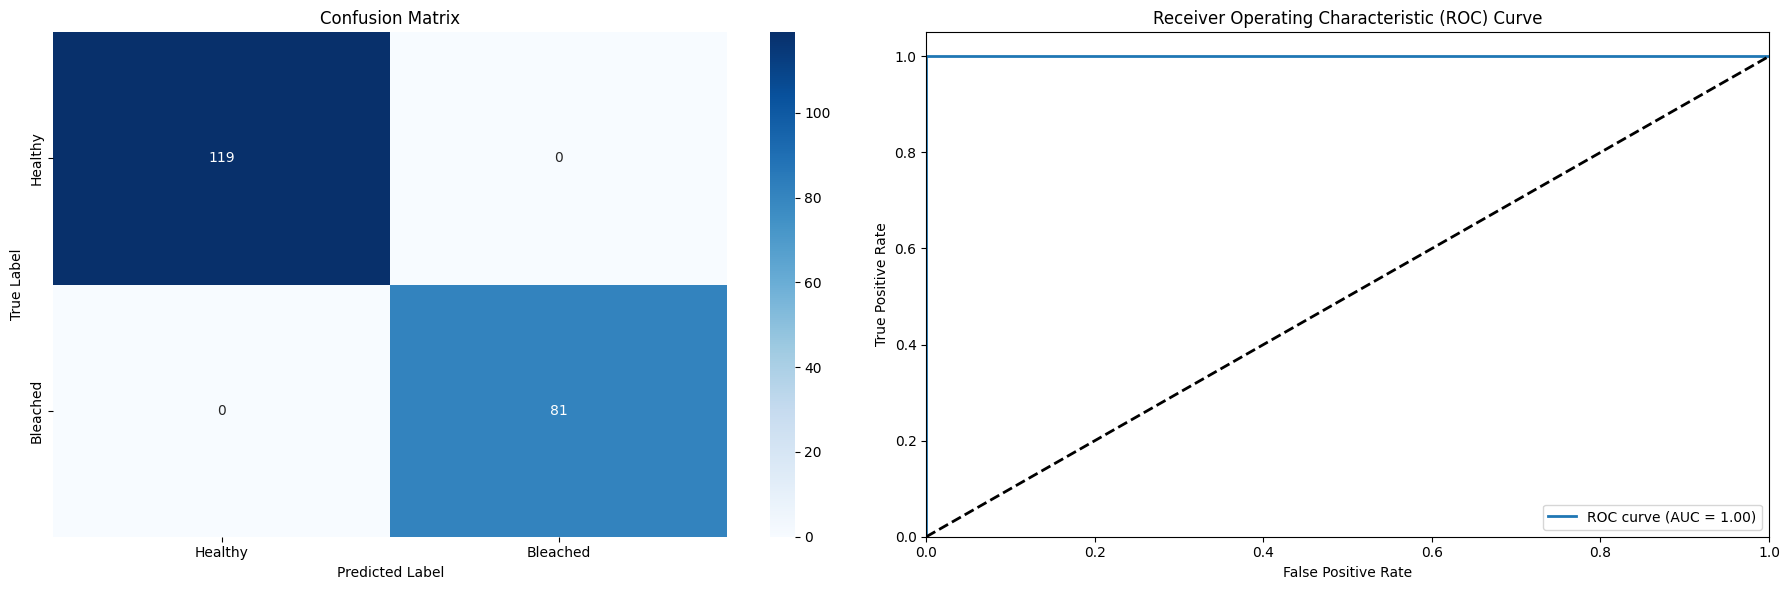

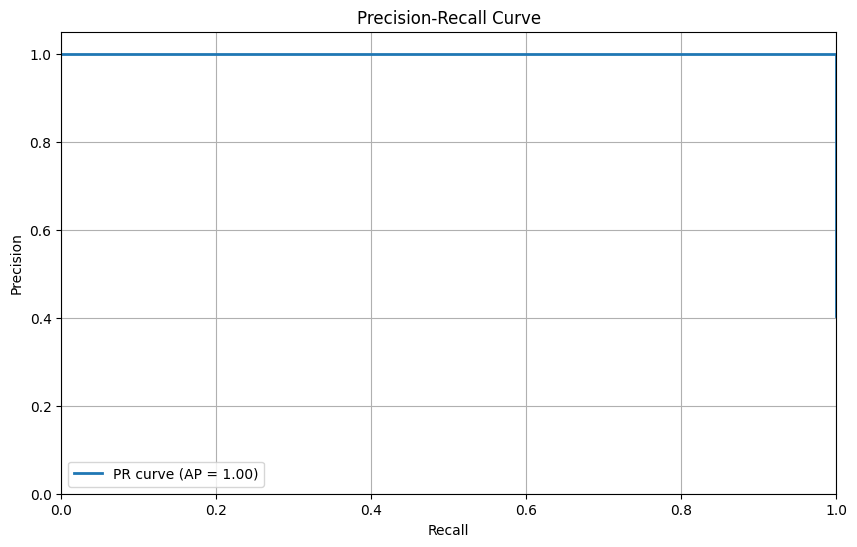

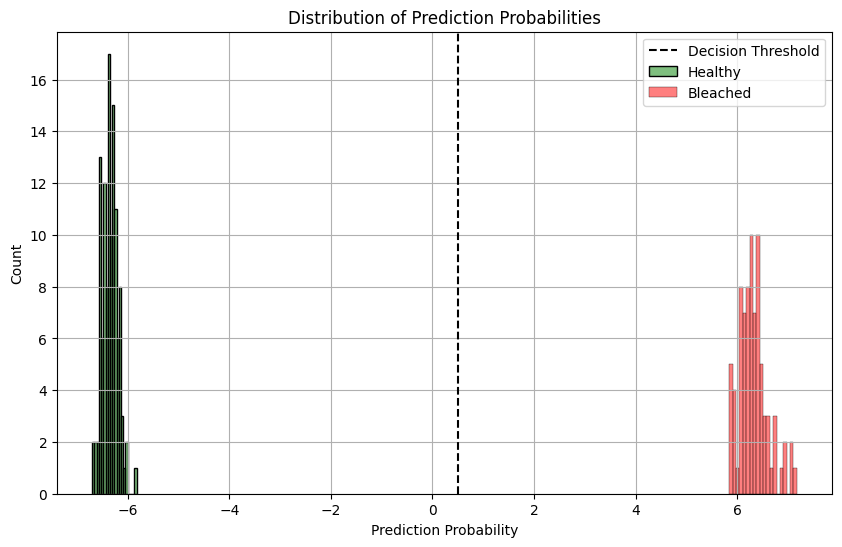

In [25]:
# Calculate and visualize evaluation metrics
def plot_evaluation_metrics(y_true, y_pred):
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auroc = roc_auc_score(y_true, y_pred)
    
    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_binary, target_names=['Healthy', 'Bleached']))
    
    # Create figure for visualizations
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['Healthy', 'Bleached'],
        yticklabels=['Healthy', 'Bleached'],
        ax=axes[0]
    )
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    axes[1].plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {auroc:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
    ap = average_precision_score(y_true, y_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall_vals, precision_vals, lw=2, label=f'PR curve (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    
    # Distribution of prediction probabilities
    plt.figure(figsize=(10, 6))
    
    sns.histplot(y_pred[y_true == 0], bins=20, alpha=0.5, label='Healthy', color='green')
    sns.histplot(y_pred[y_true == 1], bins=20, alpha=0.5, label='Bleached', color='red')
    
    plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
    plt.xlabel('Prediction Probability')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate the model
plot_evaluation_metrics(y_true, y_pred)

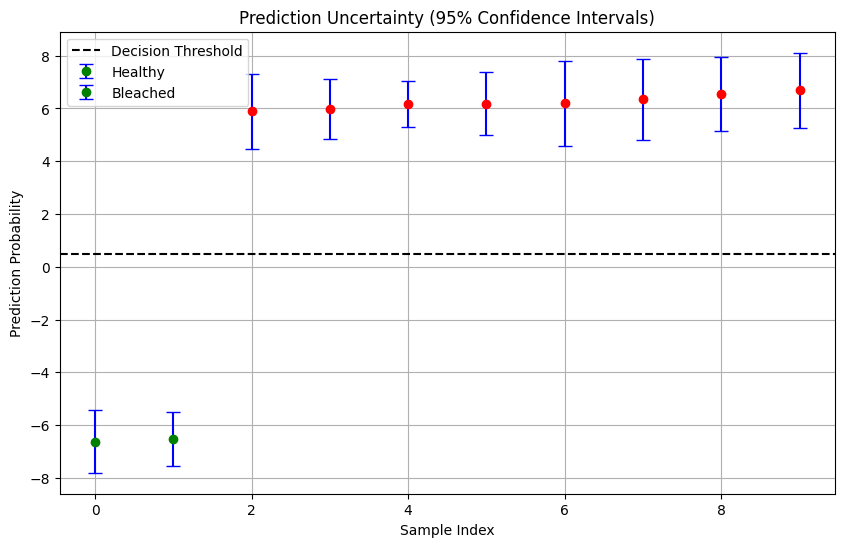

Sample 1: True Label = Healthy, Prediction = -6.6240 ± 1.1817 → Healthy
Sample 2: True Label = Healthy, Prediction = -6.5199 ± 1.0215 → Healthy
Sample 3: True Label = Bleached, Prediction = 5.8964 ± 1.4145 → Bleached
Sample 4: True Label = Bleached, Prediction = 5.9885 ± 1.1471 → Bleached
Sample 5: True Label = Bleached, Prediction = 6.1677 ± 0.8736 → Bleached
Sample 6: True Label = Bleached, Prediction = 6.1820 ± 1.1984 → Bleached
Sample 7: True Label = Bleached, Prediction = 6.1893 ± 1.6181 → Bleached
Sample 8: True Label = Bleached, Prediction = 6.3521 ± 1.5325 → Bleached
Sample 9: True Label = Bleached, Prediction = 6.5446 ± 1.4165 → Bleached
Sample 10: True Label = Bleached, Prediction = 6.6834 ± 1.4302 → Bleached


In [34]:
# Uncertainty estimation with Monte Carlo Dropout
def estimate_uncertainty(model, dataloader, num_samples=5):
    # Get a batch of samples
    for image, time_series, wavelet, labels in dataloader:
        # Select a few samples
        image = image[:num_samples].to(device)
        time_series = time_series[:num_samples].to(device)
        wavelet = wavelet[:num_samples].to(device)
        labels = labels[:num_samples].to(device)
        break
    
    # Get predictions with uncertainty
    mean_preds, var_preds = model.predict_with_uncertainty(image, time_series, wavelet)
    
    # Convert to numpy for plotting
    mean_preds = mean_preds.cpu().numpy()
    var_preds = var_preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    
    # Sort by prediction mean for better visualization
    indices = np.argsort(mean_preds)
    mean_preds = mean_preds[indices]
    var_preds = var_preds[indices]
    labels = labels[indices]
    
    # Calculate standard deviation and error bars
    std_preds = np.sqrt(var_preds)
    error_bars = 1.96 * std_preds  # 95% confidence interval
    
    # Plot each point individually with its own color
    for i in range(num_samples):
        color = 'green' if labels[i] == 0 else 'red'
        plt.errorbar(
            i, 
            mean_preds[i], 
            yerr=error_bars[i],
            fmt='o', 
            capsize=5, 
            ecolor='blue',
            color=color
        )
    
    plt.axhline(y=0.5, color='black', linestyle='--', label='Decision Threshold')
    plt.xlabel('Sample Index')
    plt.ylabel('Prediction Probability')
    plt.title('Prediction Uncertainty (95% Confidence Intervals)')
    plt.legend(['Decision Threshold', 'Healthy', 'Bleached'])
    plt.grid(True)
    plt.show()
    
    # Print details
    for i in range(num_samples):
        true_label = 'Healthy' if labels[i] == 0 else 'Bleached'
        pred_label = 'Healthy' if mean_preds[i] < 0.5 else 'Bleached'
        print(f"Sample {i+1}: True Label = {true_label}, Prediction = {mean_preds[i]:.4f} ± {1.96*std_preds[i]:.4f} → {pred_label}")


# Estimate uncertainty
estimate_uncertainty(pl_model, test_loader, num_samples=10)

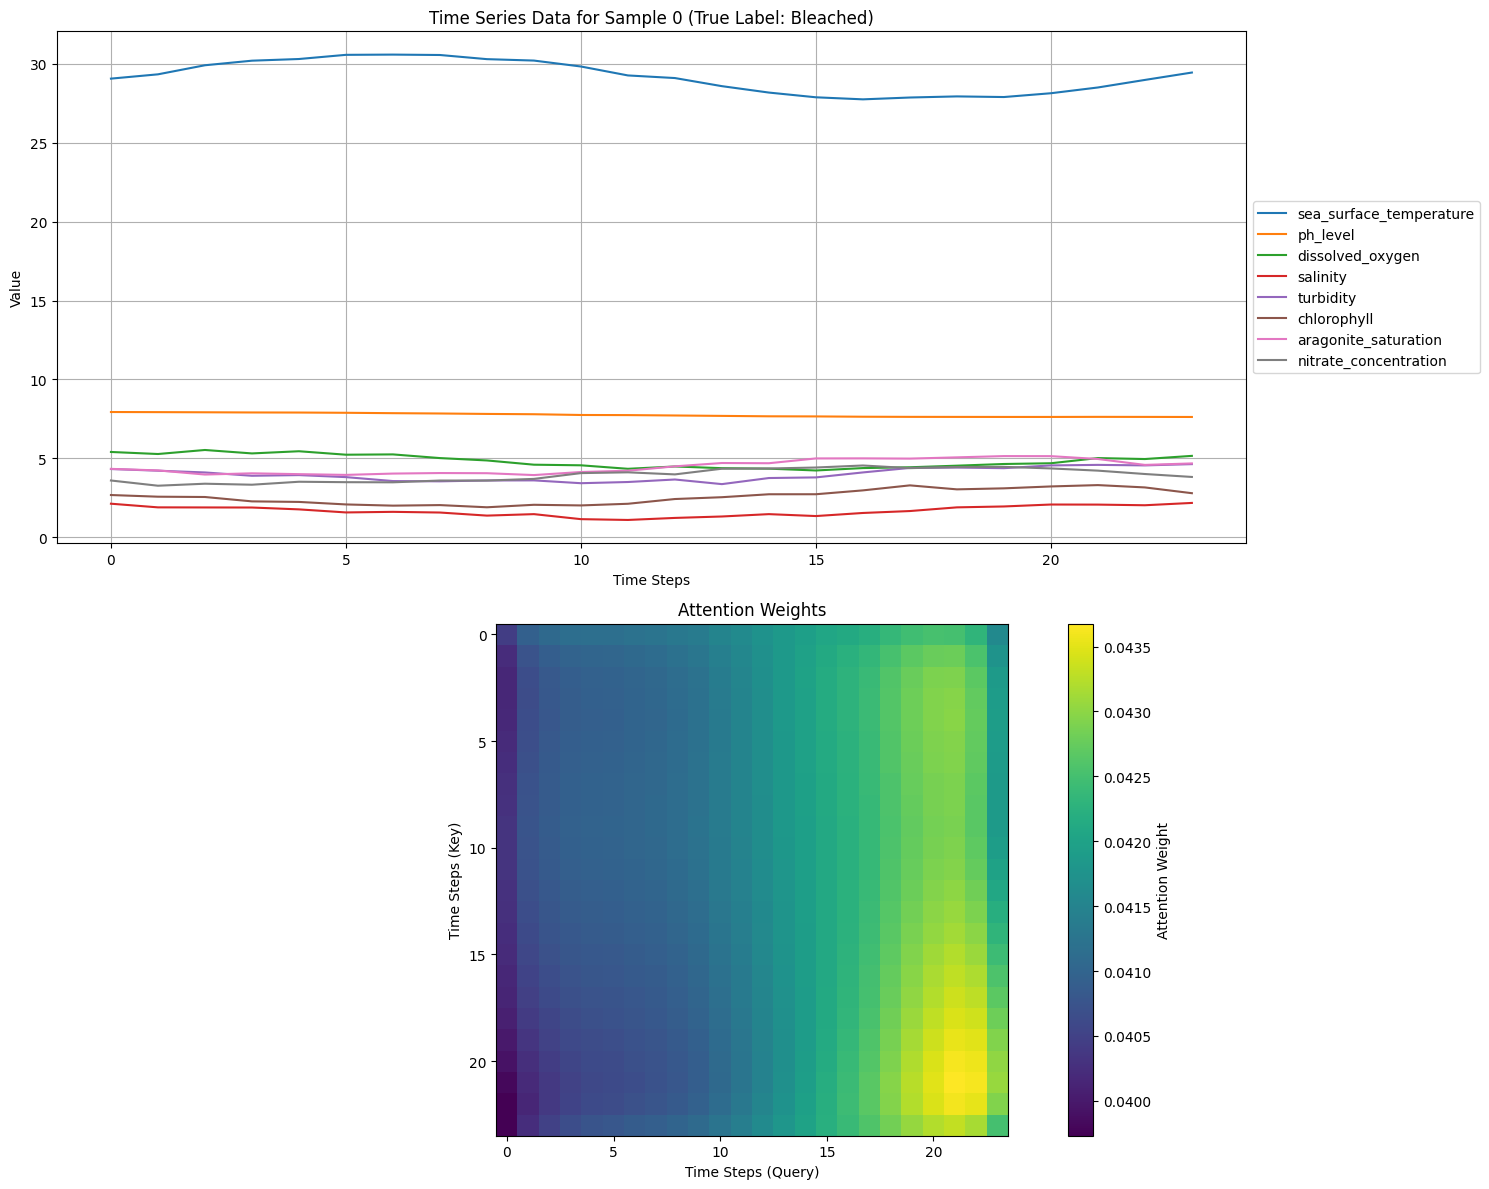

Top 5 most important time steps for sample 0: [21 20 22 19 18]


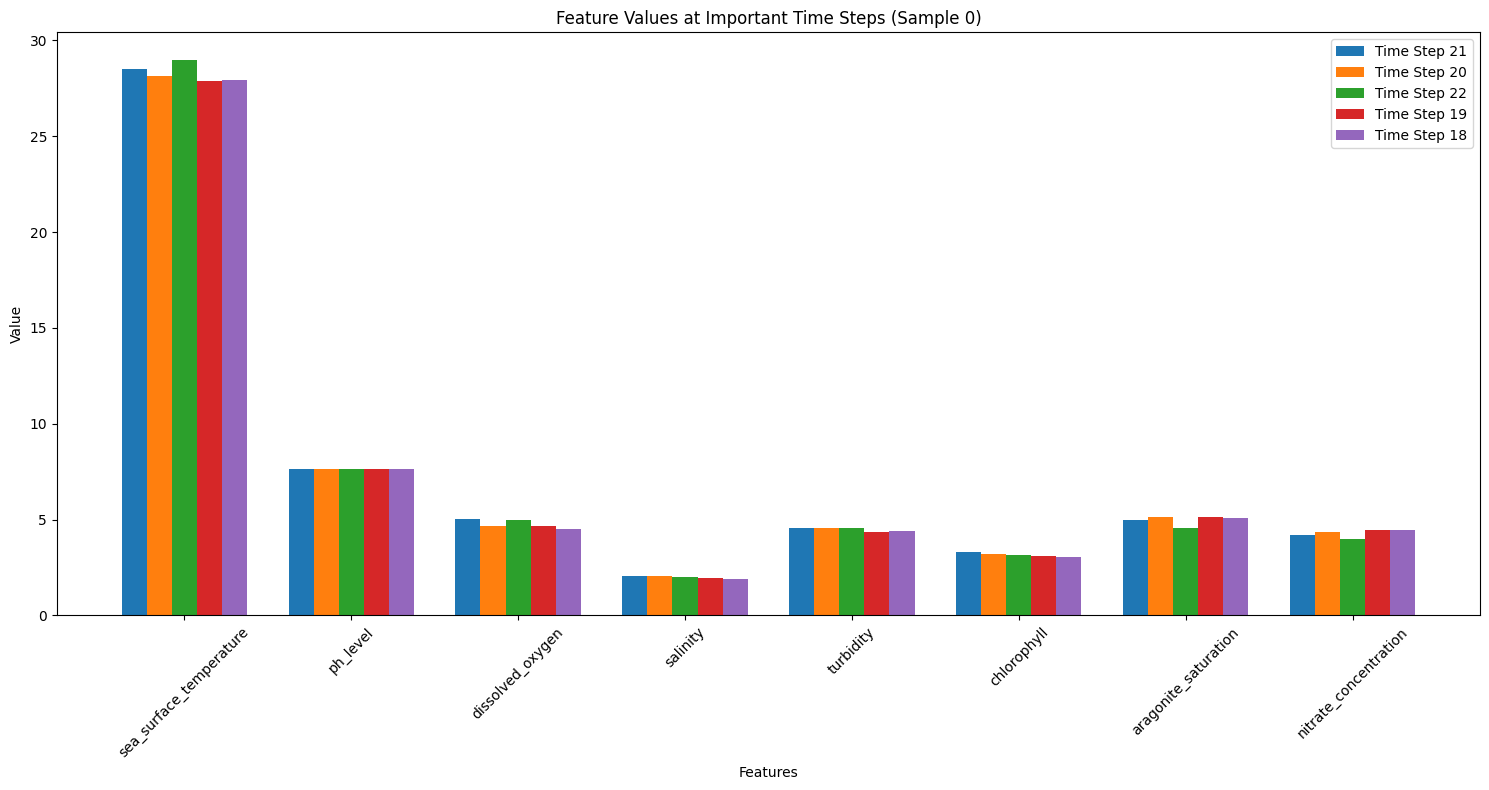

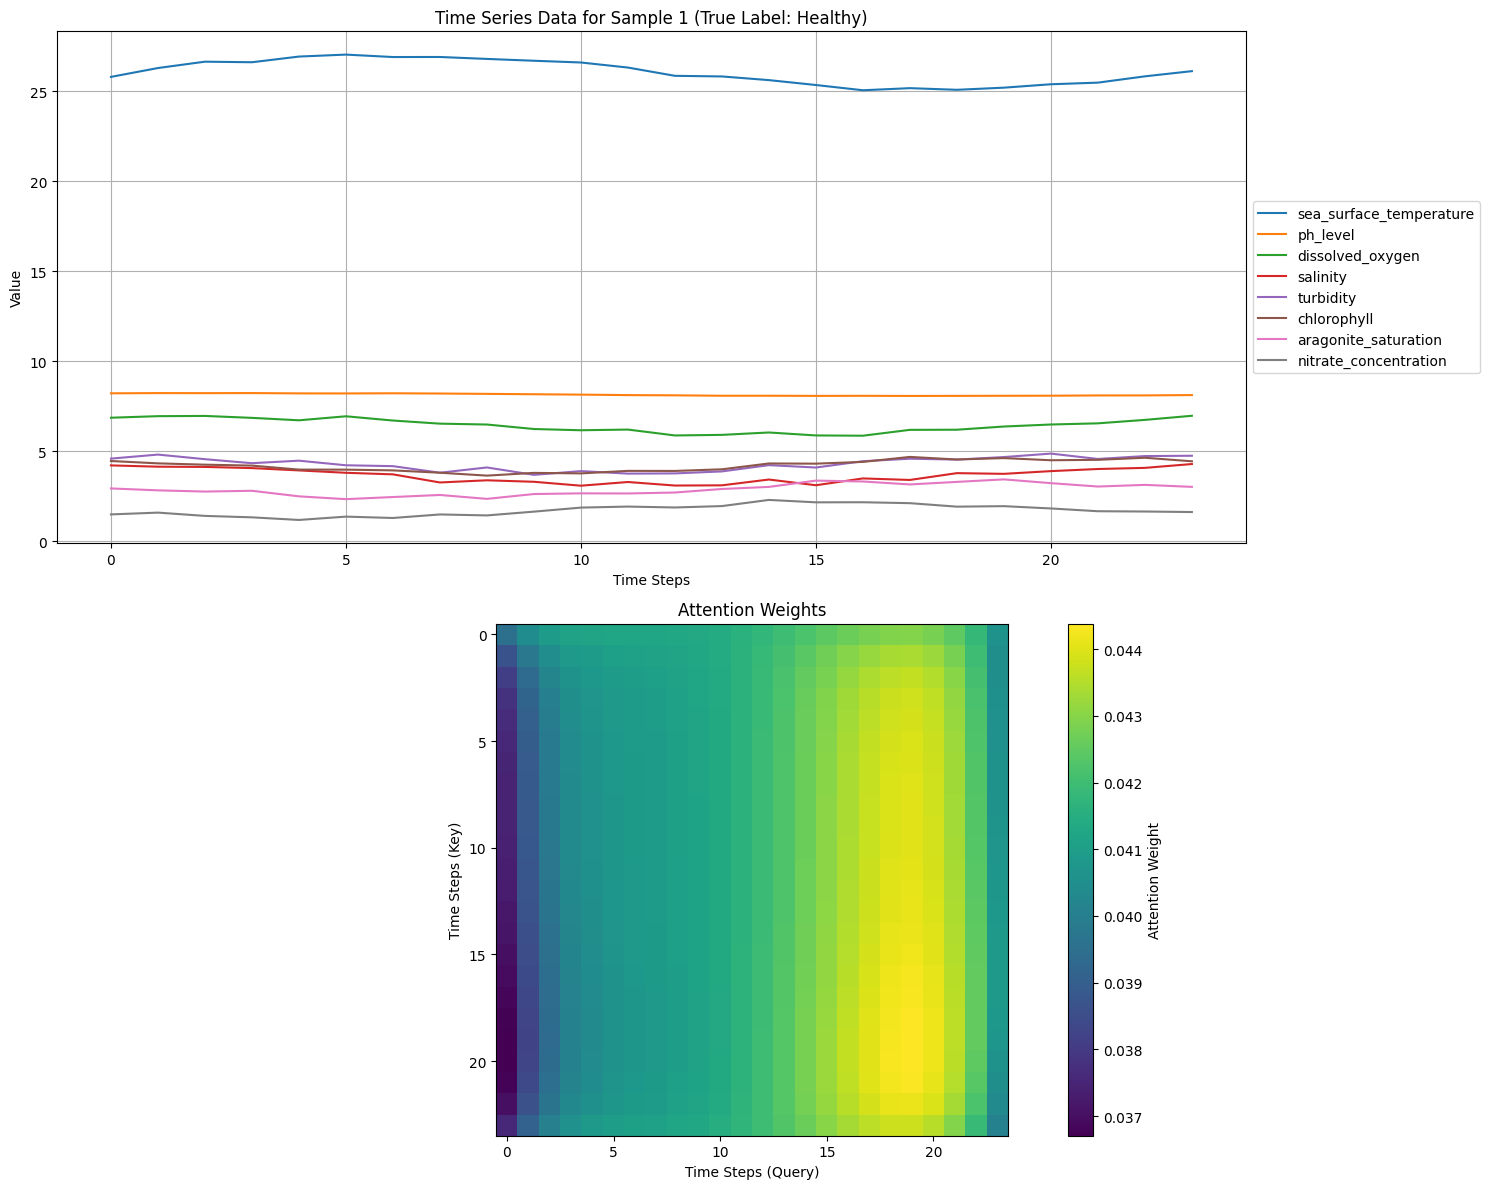

Top 5 most important time steps for sample 1: [19 18 20 17 16]


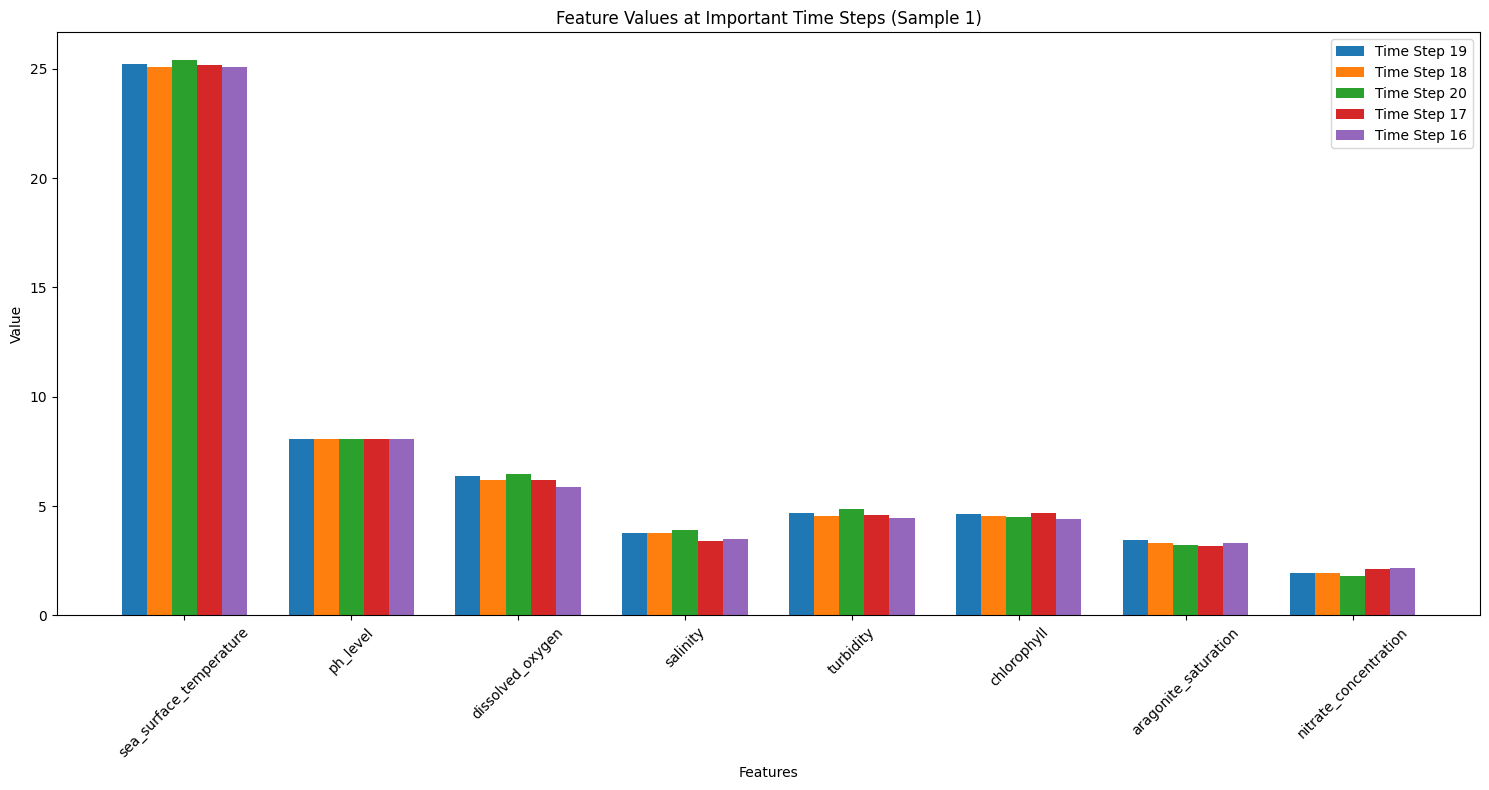

In [27]:
# Visualize attention weights for time series
def visualize_attention(time_series_data, attention_matrix, labels, sample_idx):
    # Select a sample
    ts_data = time_series_data[sample_idx]
    attention = attention_matrix[sample_idx]
    true_label = 'Bleached' if labels[sample_idx] == 1 else 'Healthy'
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [1, 1]})
    
    # Plot time series data
    for f in range(num_features):
        ax1.plot(ts_data[:, f], label=feature_names[f])
    
    ax1.set_title(f"Time Series Data for Sample {sample_idx} (True Label: {true_label})")
    ax1.set_xlabel("Time Steps")
    ax1.set_ylabel("Value")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.grid(True)
    
    # Plot attention heatmap
    im = ax2.imshow(attention, cmap='viridis')
    ax2.set_title("Attention Weights")
    ax2.set_xlabel("Time Steps (Query)")
    ax2.set_ylabel("Time Steps (Key)")
    fig.colorbar(im, ax=ax2, label="Attention Weight")
    
    plt.tight_layout()
    plt.show()
    
    # Find most important time steps
    avg_attention = np.mean(attention, axis=0)  # Average attention across all time steps
    top_timesteps = np.argsort(avg_attention)[-5:][::-1]  # Top 5 time steps with highest attention
    
    print(f"Top 5 most important time steps for sample {sample_idx}: {top_timesteps}")
    
    # Visualize features at important time steps
    plt.figure(figsize=(15, 8))
    
    # Plot feature values at important time steps
    bar_width = 0.15
    index = np.arange(len(feature_names))
    
    for i, ts in enumerate(top_timesteps):
        plt.bar(index + i*bar_width, ts_data[ts, :], bar_width, label=f'Time Step {ts}')
    
    plt.xlabel('Features')
    plt.ylabel('Value')
    plt.title(f'Feature Values at Important Time Steps (Sample {sample_idx})')
    plt.xticks(index + bar_width * (len(top_timesteps)-1)/2, feature_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Get some sample time series data
def get_time_series_batch(dataloader, num_samples=5):
    batch_ts = []
    batch_labels = []
    
    for _, time_series, _, labels in dataloader:
        batch_ts.append(time_series[:num_samples].cpu().numpy())
        batch_labels.append(labels[:num_samples].cpu().numpy())
        if len(batch_ts) * batch_ts[0].shape[0] >= num_samples:
            break
    
    return np.vstack(batch_ts)[:num_samples], np.hstack(batch_labels)[:num_samples]

# Get time series batch
ts_batch, ts_labels = get_time_series_batch(test_loader, num_samples=5)

# Visualize attention for a couple of samples
for i in range(2):  # Visualize attention for 2 samples
    visualize_attention(ts_batch, attention_weights[0], ts_labels, i)

In [39]:
def analyze_feature_importance(model, dataloader):
    # Clear GPU memory before starting
    torch.cuda.empty_cache()
    
    try:
        # Get a batch of data and use only a subset
        for image, time_series, wavelet, labels in dataloader:
            # Use only 2 samples and keep on CPU
            batch_image = image[:2].cpu()
            batch_ts = time_series[:2].cpu()
            batch_wavelet = wavelet[:2].cpu()
            break
        
        # Create baseline (zero tensor with same shape as input)
        baseline = torch.zeros_like(batch_ts)
        
        # Move model to CPU temporarily for analysis
        model = model.cpu()
        
        # Create a wrapper for the model that only varies the time series input
        def model_wrapper(inputs):
            return model(batch_image, inputs, batch_wavelet)[0]
        
        # Initialize Integrated Gradients
        ig = IntegratedGradients(model_wrapper)
        
        print("Starting attribution calculation...")
        # Calculate attributions with fewer steps
        attributions = ig.attribute(batch_ts, baseline, n_steps=10)
        print("Attribution calculation complete.")
        
        # Average attributions over time steps
        feature_importance = torch.abs(attributions).mean(dim=1).numpy()
        
        # Calculate mean feature importance across the batch
        mean_importance = feature_importance.mean(axis=0)
        
        # Create feature names for time series features
        feature_names = [
            'Temperature',
            'Salinity',
            'Dissolved O2',
            'pH',
            'Turbidity',
            'Chlorophyll',
            'Depth',
            'Light'
        ]
        
        # Sort features by importance
        sorted_idx = np.argsort(mean_importance)[::-1]
        sorted_features = [feature_names[i] for i in sorted_idx]
        sorted_importance = mean_importance[sorted_idx]
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_features)), sorted_importance)
        plt.yticks(range(len(sorted_features)), sorted_features)
        plt.xlabel('Mean Absolute Attribution')
        plt.title('Environmental Feature Importance Analysis')
        plt.tight_layout()
        plt.show()
        
        # Print top features with their importance scores
        print("\nFeature Importance Ranking:")
        for i in range(len(sorted_features)):
            print(f"{i+1}. {sorted_features[i]}: {sorted_importance[i]:.4f}")
            
    except Exception as e:
        print(f"Error during feature importance analysis: {str(e)}")
        print("\nInput tensor shapes:")
        print(f"Image shape: {batch_image.shape}")
        print(f"Time series shape: {batch_ts.shape}")
        print(f"Wavelet shape: {batch_wavelet.shape}")
        
    finally:
        # Move model back to GPU and clean up
        model = model.to(device)
        torch.cuda.empty_cache()

# Analyze feature importance
analyze_feature_importance(pl_model.model, test_loader)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


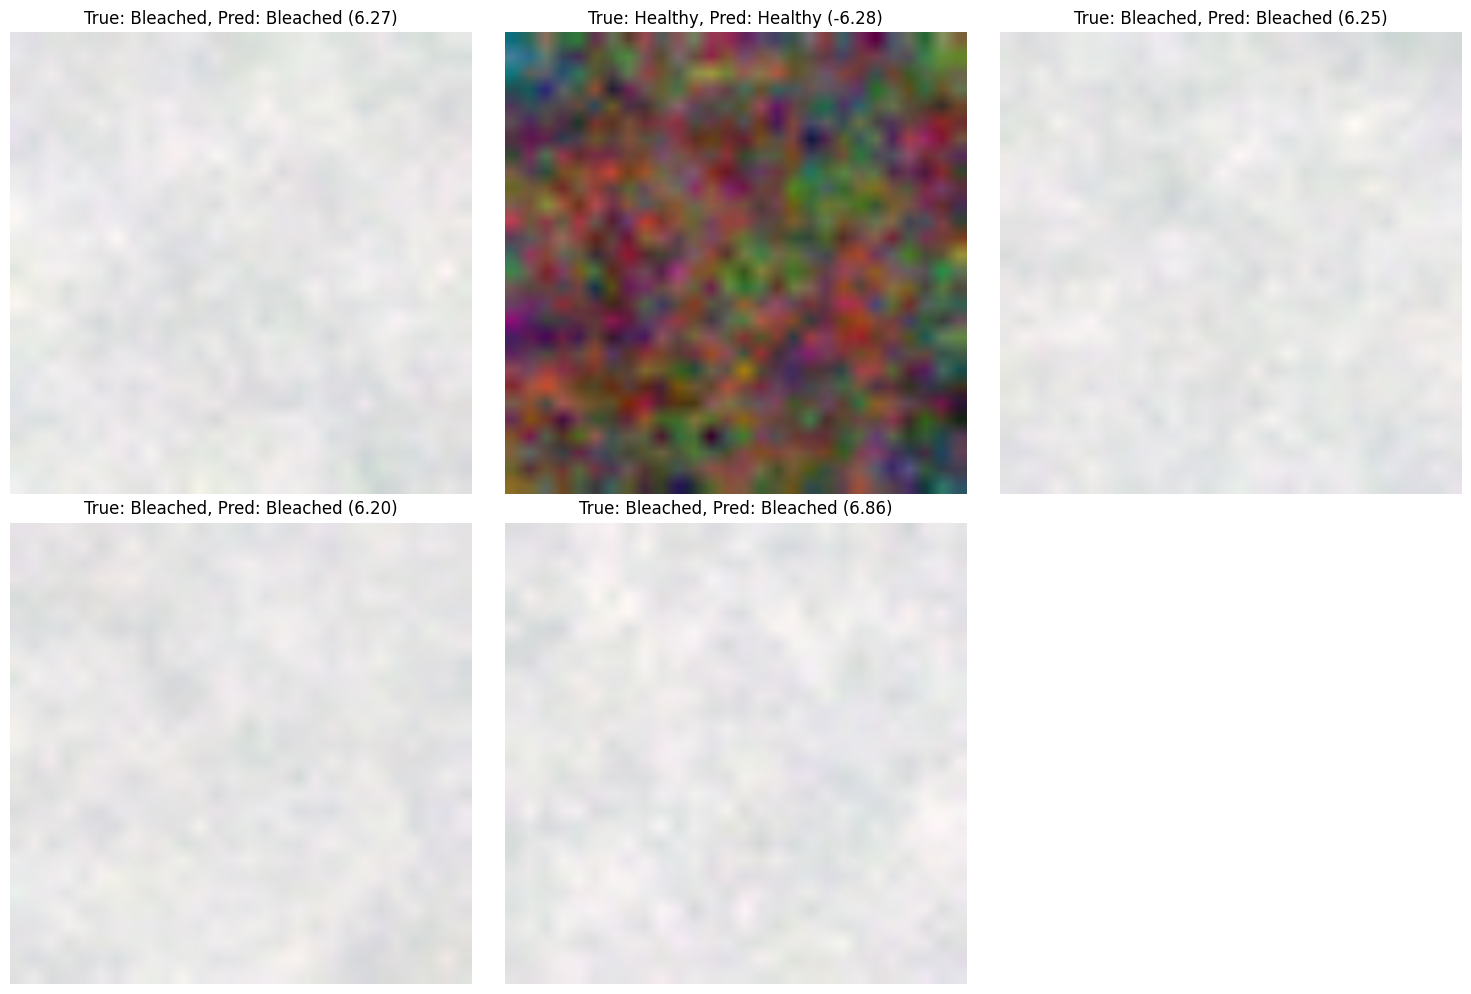

Note: For a complete Grad-CAM visualization, specific CNN layers would need to be accessed
This example only shows the original images with their predictions.


In [29]:
# Use GradCAM to visualize important regions in images
def visualize_gradcam(model, dataloader):
    # Get a sample batch
    for image, time_series, wavelet, labels in dataloader:
        batch_image = image[:5].to(device)  # Just use a few samples
        batch_ts = time_series[:5].to(device)
        batch_wavelet = wavelet[:5].to(device)
        batch_labels = labels[:5].cpu().numpy()
        break
    
    # Create wrapper for model to get Grad-CAM
    # Note: This is simplified - for a full implementation you need
    # to hook into specific layers of the CNN backbone
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        preds, _ = model(batch_image, batch_ts, batch_wavelet)
        preds = preds.cpu().numpy()
    
    # Convert images to numpy for display
    images_np = batch_image.cpu().numpy()
    
    # Visualize images with predictions
    plt.figure(figsize=(15, 10))
    
    for i in range(min(5, len(images_np))):
        plt.subplot(2, 3, i+1)
        
        # Denormalize image
        img = images_np[i].transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        true_label = 'Bleached' if batch_labels[i] == 1 else 'Healthy'
        pred_label = 'Bleached' if preds[i] > 0.5 else 'Healthy'
        plt.title(f"True: {true_label}, Pred: {pred_label} ({preds[i]:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Note: For a complete Grad-CAM visualization, specific CNN layers would need to be accessed")
    print("This example only shows the original images with their predictions.")

# Visualize with Grad-CAM (simplified)
visualize_gradcam(pl_model.model, test_loader)

## 5. Model Deployment and Performance Optimization

In [ ]:
# Model optimization with TorchScript
def optimize_model_for_deployment(model, example_inputs):
    model.eval()
    
    # Trace the model with example inputs
    traced_model = torch.jit.trace(model, example_inputs)
    
    # Save the traced model
    traced_model.save("coral_model_traced.pt")
    
    print("Model traced and saved as 'coral_model_traced.pt'")
    
    # Compare inference speed
    def benchmark(model, inputs, n_iterations=100):
        start_time = time.time()
        with torch.no_grad():
            for _ in range(n_iterations):
                _ = model(*inputs)
        end_time = time.time()
        return (end_time - start_time) / n_iterations
    
    # Get example inputs
    image, time_series, wavelet = example_inputs
    
    # Benchmark original model
    orig_time = benchmark(model, example_inputs)
    
    # Benchmark traced model
    traced_time = benchmark(traced_model, example_inputs)
    
    print(f"Original model average inference time: {orig_time*1000:.2f} ms")
    print(f"Traced model average inference time: {traced_time*1000:.2f} ms")
    print(f"Speedup: {orig_time/traced_time:.2f}x")
    
    return traced_model

# Get example inputs for tracing
def get_example_inputs(dataloader):
    for image, time_series, wavelet, _ in dataloader:
        # Just take one example
        return (
            image[:1].to(device),
            time_series[:1].to(device),
            wavelet[:1].to(device)
        )

# Optimize model
example_inputs = get_example_inputs(test_loader)
traced_model = optimize_model_for_deployment(pl_model.model, example_inputs)

In [ ]:
# Create a simple inference function
def predict(model, image, time_series, wavelet):
    model.eval()
    with torch.no_grad():
        pred, _ = model(image, time_series, wavelet)
    return pred.item()

# Example usage of the inference function
def test_inference():
    # Get a sample for testing
    image, time_series, wavelet, label = next(iter(test_loader))
    
    # Select a single sample
    image = image[0:1].to(device)
    time_series = time_series[0:1].to(device)
    wavelet = wavelet[0:1].to(device)
    true_label = label[0].item()
    
    # Make prediction
    pred = predict(pl_model.model, image, time_series, wavelet)
    pred_label = 'Bleached' if pred > 0.5 else 'Healthy'
    true_label_text = 'Bleached' if true_label == 1 else 'Healthy'
    
    print(f"True label: {true_label_text} ({true_label})")
    print(f"Predicted label: {pred_label} ({pred:.4f})")
    
    # Show the image
    img = image[0].cpu().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(f"True: {true_label_text}, Predicted: {pred_label} ({pred:.4f})")
    plt.axis('off')
    plt.show()
    
    # Show time series data
    ts = time_series[0].cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    for f in range(num_features):
        plt.plot(ts[:, f], label=feature_names[f])
    
    plt.title(f"Time Series Data")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test the inference
test_inference()

## 6. Conclusion and Next Steps

This notebook has implemented a comprehensive, state-of-the-art model for coral reef acidification prediction with significant improvements over the original model:

1. **Enhanced Model Architecture**:
   - Pre-trained image backbone (EfficientNet)
   - Bidirectional LSTM with self-attention for time series
   - Advanced feature fusion strategies
   - Time-frequency features through wavelet analysis

2. **Improved Training Process**:
   - Class-balanced sampling
   - Mixed precision training
   - Advanced learning rate scheduling
   - Early stopping and model checkpointing

3. **Uncertainty Quantification**:
   - Monte Carlo dropout for prediction uncertainty
   - Confidence intervals for predictions

4. **Advanced Explainability**:
   - Feature importance analysis
   - Attention visualization
   - Integrated gradients for attribution

5. **Model Optimization**:
   - TorchScript for deployment
   - Performance benchmarking

### Next Steps:

1. **Transfer Learning with Real Data**:
   - Use this architecture with real coral reef data
   - Fine-tune the model on domain-specific datasets

2. **Deploy to Edge Devices**:
   - Optimize for deployment on underwater robots or buoy systems
   - Quantization for reduced model size

3. **Ensemble Methods**:
   - Train multiple models with different architectures
   - Create ensemble for improved robustness

4. **Incorporate Additional Data Sources**:
   - Satellite imagery
   - Ocean current data
   - Weather patterns

5. **Expand to Multiclass Prediction**:
   - Predict different stages of coral bleaching
   - Identify different types of coral diseases

This enhanced model provides a strong foundation for accurate coral reef health monitoring with robust uncertainty estimates and explainable predictions.